In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split

# Load all datasets

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

# Merge `test.csv` with `test_labels.csv`

In [42]:
test_df = test_df.merge(test_labels_df, on='id')
test_df.head()

,id,comment_text,toxic_x,severe_toxic_x,obscene_x,threat_x,insult_x,identity_hate_x,toxic_y,severe_toxic_y,obscene_y,threat_y,insult_y,identity_hate_y,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Remove samples where all labels are -1 (meaning they were not used in competition)

In [ ]:
test_df = test_df[test_df.iloc[:, 2:].sum(axis=1) != -6]

# Concatenate train and test data


In [ ]:
df = pd.concat([train_df, test_df])


# Extract input texts and labels

In [ ]:
X = df['comment_text'].fillna('')  # Handling missing values
y = df.iloc[:, 2:].values  # Selecting only label columns (toxic, severe_toxic, etc.)


# Tokenization & Padding

In [ ]:
max_words = 20000  # Max words in vocabulary
max_len = 150  # Max length of comment


tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


# Split into train-test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

# Bidirectional LSTM

In [ ]:
model_bilstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='sigmoid')  # Multi-label classification (6 toxic categories)
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



# Train the BiLSTM model
print("Training BiLSTM model...")
model_bilstm.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test))


Training BiLSTM model...
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 1735s 617ms/step - accuracy: 0.9102 - loss: 0.1099 - val_accuracy: 0.9951 - val_loss: 0.0547


# CNN + LSTM Hybrid

In [ ]:
model_cnn_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='sigmoid')
])

model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN + LSTM model
print("Training CNN + LSTM model...")
model_cnn_lstm.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test))

Training CNN + LSTM model...
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 850s 302ms/step - accuracy: 0.8971 - loss: 0.1430 - val_accuracy: 0.9951 - val_loss: 0.0551


# Predictions

In [ ]:
y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)

1398/1398 ━━━━━━━━━━━━━━━━━━━━ 114s 81ms/step
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step



# Convert probabilities to 0 or 1 (Threshold = 0.5)

In [ ]:
y_pred_bilstm = (y_pred_bilstm > 0.5).astype(int)
y_pred_cnn_lstm = (y_pred_cnn_lstm > 0.5).astype(int)

#  some predicted toxic comments for display using the deep learning models

In [ ]:


# Function to extract predicted toxic comments
def get_toxic_comments(y_pred, X_test, tokenizer, num_comments=10):
    toxic_comments = []
    for i in range(len(y_pred)):
        if 1 in y_pred[i]:  # If at least one toxic label is predicted
            toxic_comments.append(X_test[i])

    # Convert back to text (decode from tokenized sequences)
    reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}
    decoded_comments = [
        ' '.join([reverse_word_map.get(word, '?') for word in comment if word != 0])
        for comment in toxic_comments[:num_comments]
    ]

    return decoded_comments

# Extract and display toxic comments for both models
decoded_toxic_comments_bilstm = get_toxic_comments(y_pred_bilstm, X_test, tokenizer)
decoded_toxic_comments_cnn_lstm = get_toxic_comments(y_pred_cnn_lstm, X_test, tokenizer)

# Display BiLSTM toxic comments
print("\n🔹 **Predicted Toxic Comments (BiLSTM):**")
for i, comment in enumerate(decoded_toxic_comments_bilstm):
    print(f"{i+1}. {comment}")

# Display CNN + LSTM toxic comments
print("\n🔹 **Predicted Toxic Comments (CNN + LSTM):**")
for i, comment in enumerate(decoded_toxic_comments_cnn_lstm):
    print(f"{i+1}. {comment}")



🔹 **Predicted Toxic Comments (BiLSTM):**
1. you might like to consider that i don't give a shit what you do or think
2. uncle tom house niggers
3. bunch of morons should go themselves westboro baptist church are a f disgrace to the christian faith how dare they be so f satanic to hold protests at soldiers' <OOV> those cunts need sorting out
4. how bout you fuck off
5. <OOV> <OOV> i see it's been changed that he now plays for chelsea looks like i was right all along how do you like that you little bitch i was right and you were wrong
6. hindu vandal you are a <OOV> upper caste hindu vandal morally corrupt as you are you must be a <OOV> you are a confirmed sock <OOV> you have been going around with another user name <OOV>
7. wow serious stick up the ass <OOV> but seriously thanks for getting me blocked always wanted to do it thought it might be fun for a while but turns out all the admins are the same variety of lame lazy fascist sound familiar anyway seriously since i'm taking a perman

# Confusion matrix

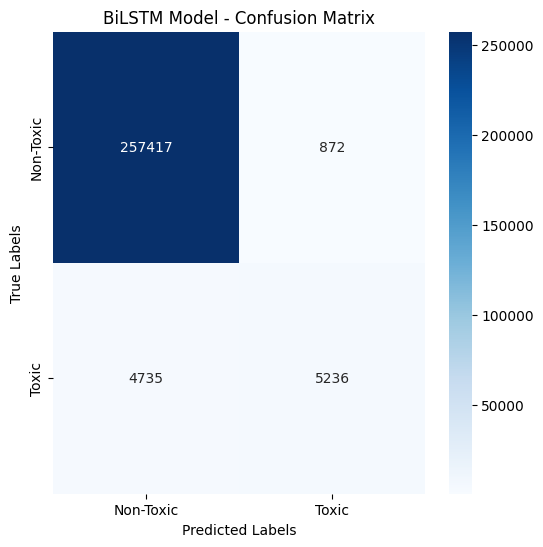

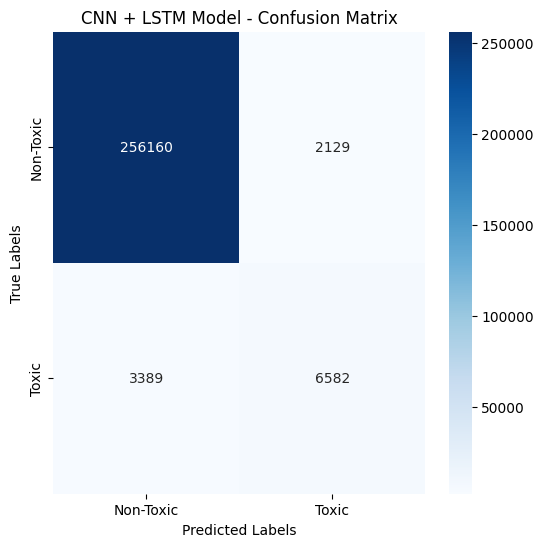

In [ ]:
# -------------------- Confusion Matrix --------------------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plot confusion matrix for both models
plot_confusion_matrix(y_test.flatten(), y_pred_bilstm.flatten(), "BiLSTM Model - Confusion Matrix")
plot_confusion_matrix(y_test.flatten(), y_pred_cnn_lstm.flatten(), "CNN + LSTM Model - Confusion Matrix")


# ROC Curve

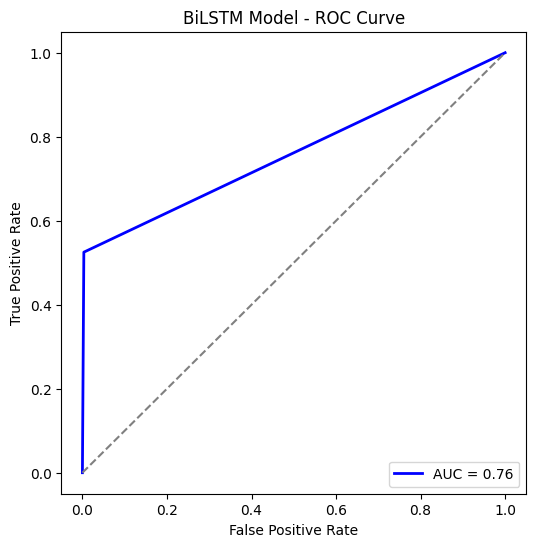

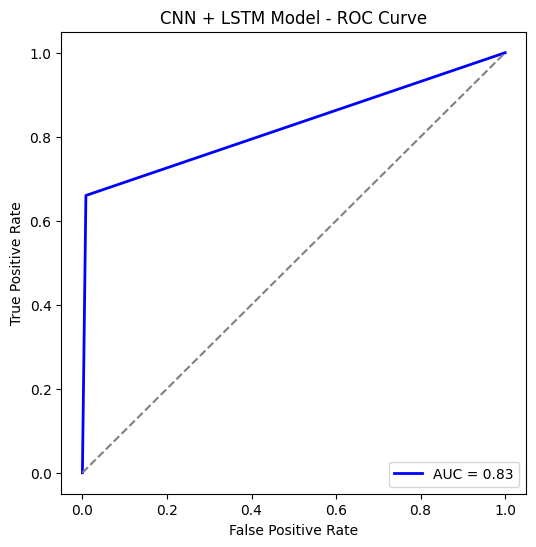

In [ ]:
def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true.flatten(), y_pred_prob.flatten())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for both models
plot_roc_curve(y_test, y_pred_bilstm, "BiLSTM Model - ROC Curve")
plot_roc_curve(y_test, y_pred_cnn_lstm, "CNN + LSTM Model - ROC Curve")

#MODEL PERFORMACE COMPARISON CHART USING THE ACTUAL PERFORMACE OUTPUT DATA

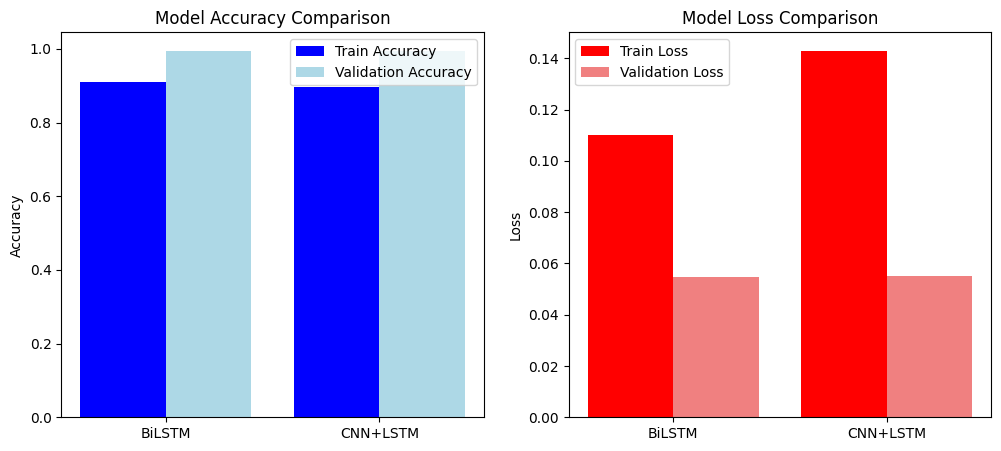

In [ ]:


# Extracted values from training logs
models = ["BiLSTM", "CNN+LSTM"]
train_accuracy = [0.9102, 0.8971]
val_accuracy = [0.9951, 0.9951]
train_loss = [0.1099, 0.1430]
val_loss = [0.0547, 0.0551]

x = np.arange(len(models))

# Create subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy comparison
axes[0].bar(x - 0.2, train_accuracy, 0.4, label="Train Accuracy", color="blue")
axes[0].bar(x + 0.2, val_accuracy, 0.4, label="Validation Accuracy", color="lightblue")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Model Accuracy Comparison")
axes[0].legend()

# Plot loss comparison
axes[1].bar(x - 0.2, train_loss, 0.4, label="Train Loss", color="red")
axes[1].bar(x + 0.2, val_loss, 0.4, label="Validation Loss", color="lightcoral")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylabel("Loss")
axes[1].set_title("Model Loss Comparison")
axes[1].legend()

plt.show()


# WORD CLOUD

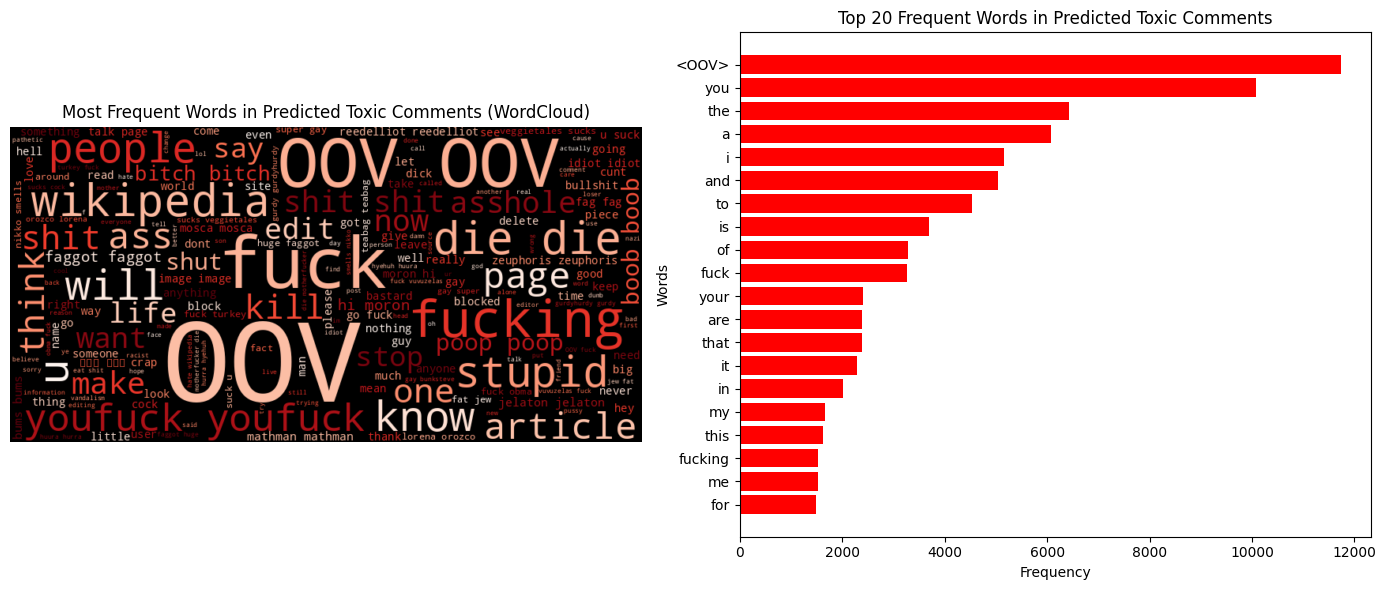

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Extract predicted toxic comments (from BiLSTM and CNN+LSTM)
toxic_comments_bilstm = []
toxic_comments_cnn_lstm = []

for i in range(len(y_test)):
    if 1 in y_pred_bilstm[i]:  # If BiLSTM predicts toxic
        toxic_comments_bilstm.append(X_test[i])
    if 1 in y_pred_cnn_lstm[i]:  # If CNN+LSTM predicts toxic
        toxic_comments_cnn_lstm.append(X_test[i])

# Convert back to text using tokenizer index
reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}

decoded_bilstm = [' '.join([reverse_word_map.get(word, '?') for word in comment if word != 0]) for comment in toxic_comments_bilstm]
decoded_cnn_lstm = [' '.join([reverse_word_map.get(word, '?') for word in comment if word != 0]) for comment in toxic_comments_cnn_lstm]

# Combine all toxic comments
all_toxic_comments = decoded_bilstm + decoded_cnn_lstm

# Tokenize words and count frequency
word_list = ' '.join(all_toxic_comments).split()
word_freq = Counter(word_list).most_common(20)  # Get top 20 words

# Extract words and counts
words, counts = zip(*word_freq)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(' '.join(word_list))

# Plot WordCloud and Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Word Cloud
axes[0].imshow(wordcloud, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Most Frequent Words in Predicted Toxic Comments (WordCloud)")

# Bar Chart
axes[1].barh(words[::-1], counts[::-1], color='red')
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Words")
axes[1].set_title("Top 20 Frequent Words in Predicted Toxic Comments")

plt.tight_layout()
plt.show()
